In [21]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import shap


  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# Load your breast cancer dataset
# Replace this with your own data loading method
data = pd.read_csv(r"your_file_path")

In [17]:
data.columns

Index(['Sample code number', 'Clump Thickness', 'Uniformity of Cell Size',
       'Uniformity of Cell Shape', 'Marginal Adhesion',
       'Single Epithelial Cell Size', 'Bare Nuclei', 'Bland Chromatin',
       'Normal Nucleoli', 'Mitoses', 'Class'],
      dtype='object')

In [5]:
# Assuming the last column is the target (y) and the rest are features (X)
X = data.iloc[:, :-1]  # All columns except the last one
y = data.iloc[:, -1]   # The last column

# If your target column is labeled, you can also use:
y = data['Class']

In [6]:
# Assuming 2 should be 0 and 4 should be 1
y = y.map({2: 0, 4: 1})

# Verify the mapping
print("Mapped unique values in target:", y.unique())

Mapped unique values in target: [0 1]


In [7]:
# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Standardize the dataset (optional, but can help with convergence)
scaler = StandardScaler()

# Define the XGBoost model
xgb_model = xgb.XGBClassifier(objective='binary:logistic', random_state=42)

# Create a pipeline
pipeline = Pipeline([
    ('scaler', scaler),
    ('xgb', xgb_model)
])

In [8]:
# Define a parameter grid to search for the best parameters including L1 (reg_alpha) and L2 (reg_lambda) regularization
param_grid = {
    'xgb__n_estimators': [50, 100, 200],
    'xgb__max_depth': [3, 4, 5],
    'xgb__learning_rate': [0.01, 0.1, 0.2],
    'xgb__subsample': [0.7, 0.8, 0.9],
    'xgb__colsample_bytree': [0.7, 0.8, 0.9],
    'xgb__gamma': [0, 0.1, 0.3],
    'xgb__reg_alpha': [0, 0.01, 0.1],  # L1 regularization
    'xgb__reg_lambda': [1, 1.5, 2]     # L2 regularization
}

In [9]:
# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)

# Fit the model
grid_search.fit(X_train, y_train)

# Output the best parameters
print("Best Parameters:", grid_search.best_params_)

Fitting 5 folds for each of 6561 candidates, totalling 32805 fits
Best Parameters: {'xgb__colsample_bytree': 0.8, 'xgb__gamma': 0, 'xgb__learning_rate': 0.2, 'xgb__max_depth': 3, 'xgb__n_estimators': 50, 'xgb__reg_alpha': 0, 'xgb__reg_lambda': 1.5, 'xgb__subsample': 0.8}


In [10]:
# Make predictions with the best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.9708
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97        79
           1       0.98      0.95      0.96        58

    accuracy                           0.97       137
   macro avg       0.97      0.97      0.97       137
weighted avg       0.97      0.97      0.97       137

Confusion Matrix:
[[78  1]
 [ 3 55]]


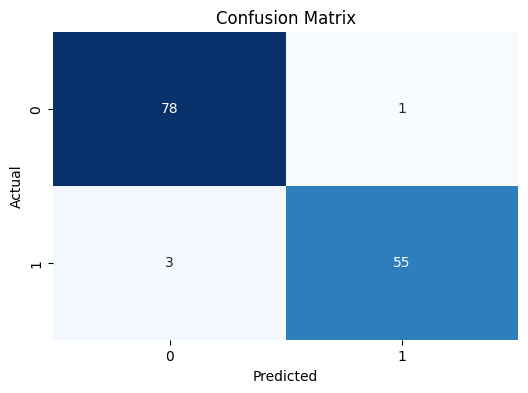

In [ ]:
# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


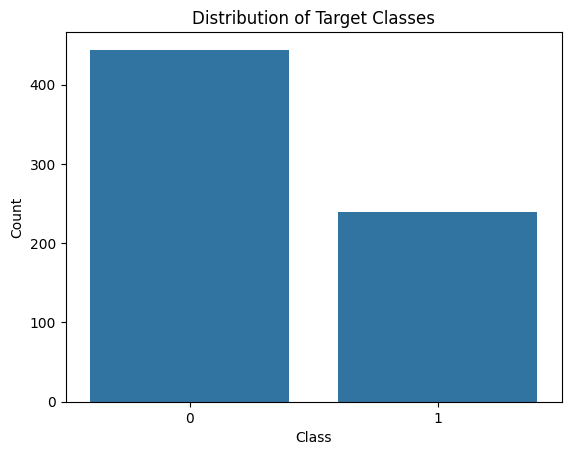

In [11]:
# Distribution of target classes
sns.countplot(x=y)
plt.title("Distribution of Target Classes")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

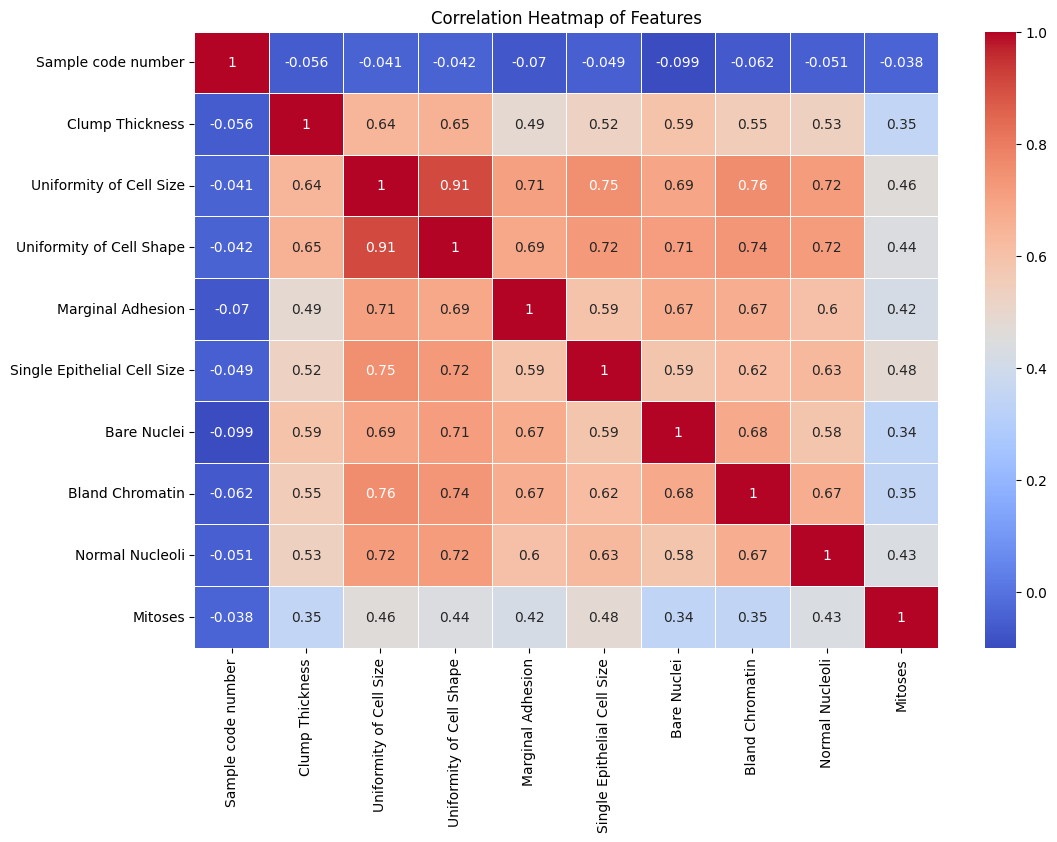

In [12]:
# Correlation matrix
plt.figure(figsize=(12, 8))
correlation_matrix = X.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Heatmap of Features")
plt.show()


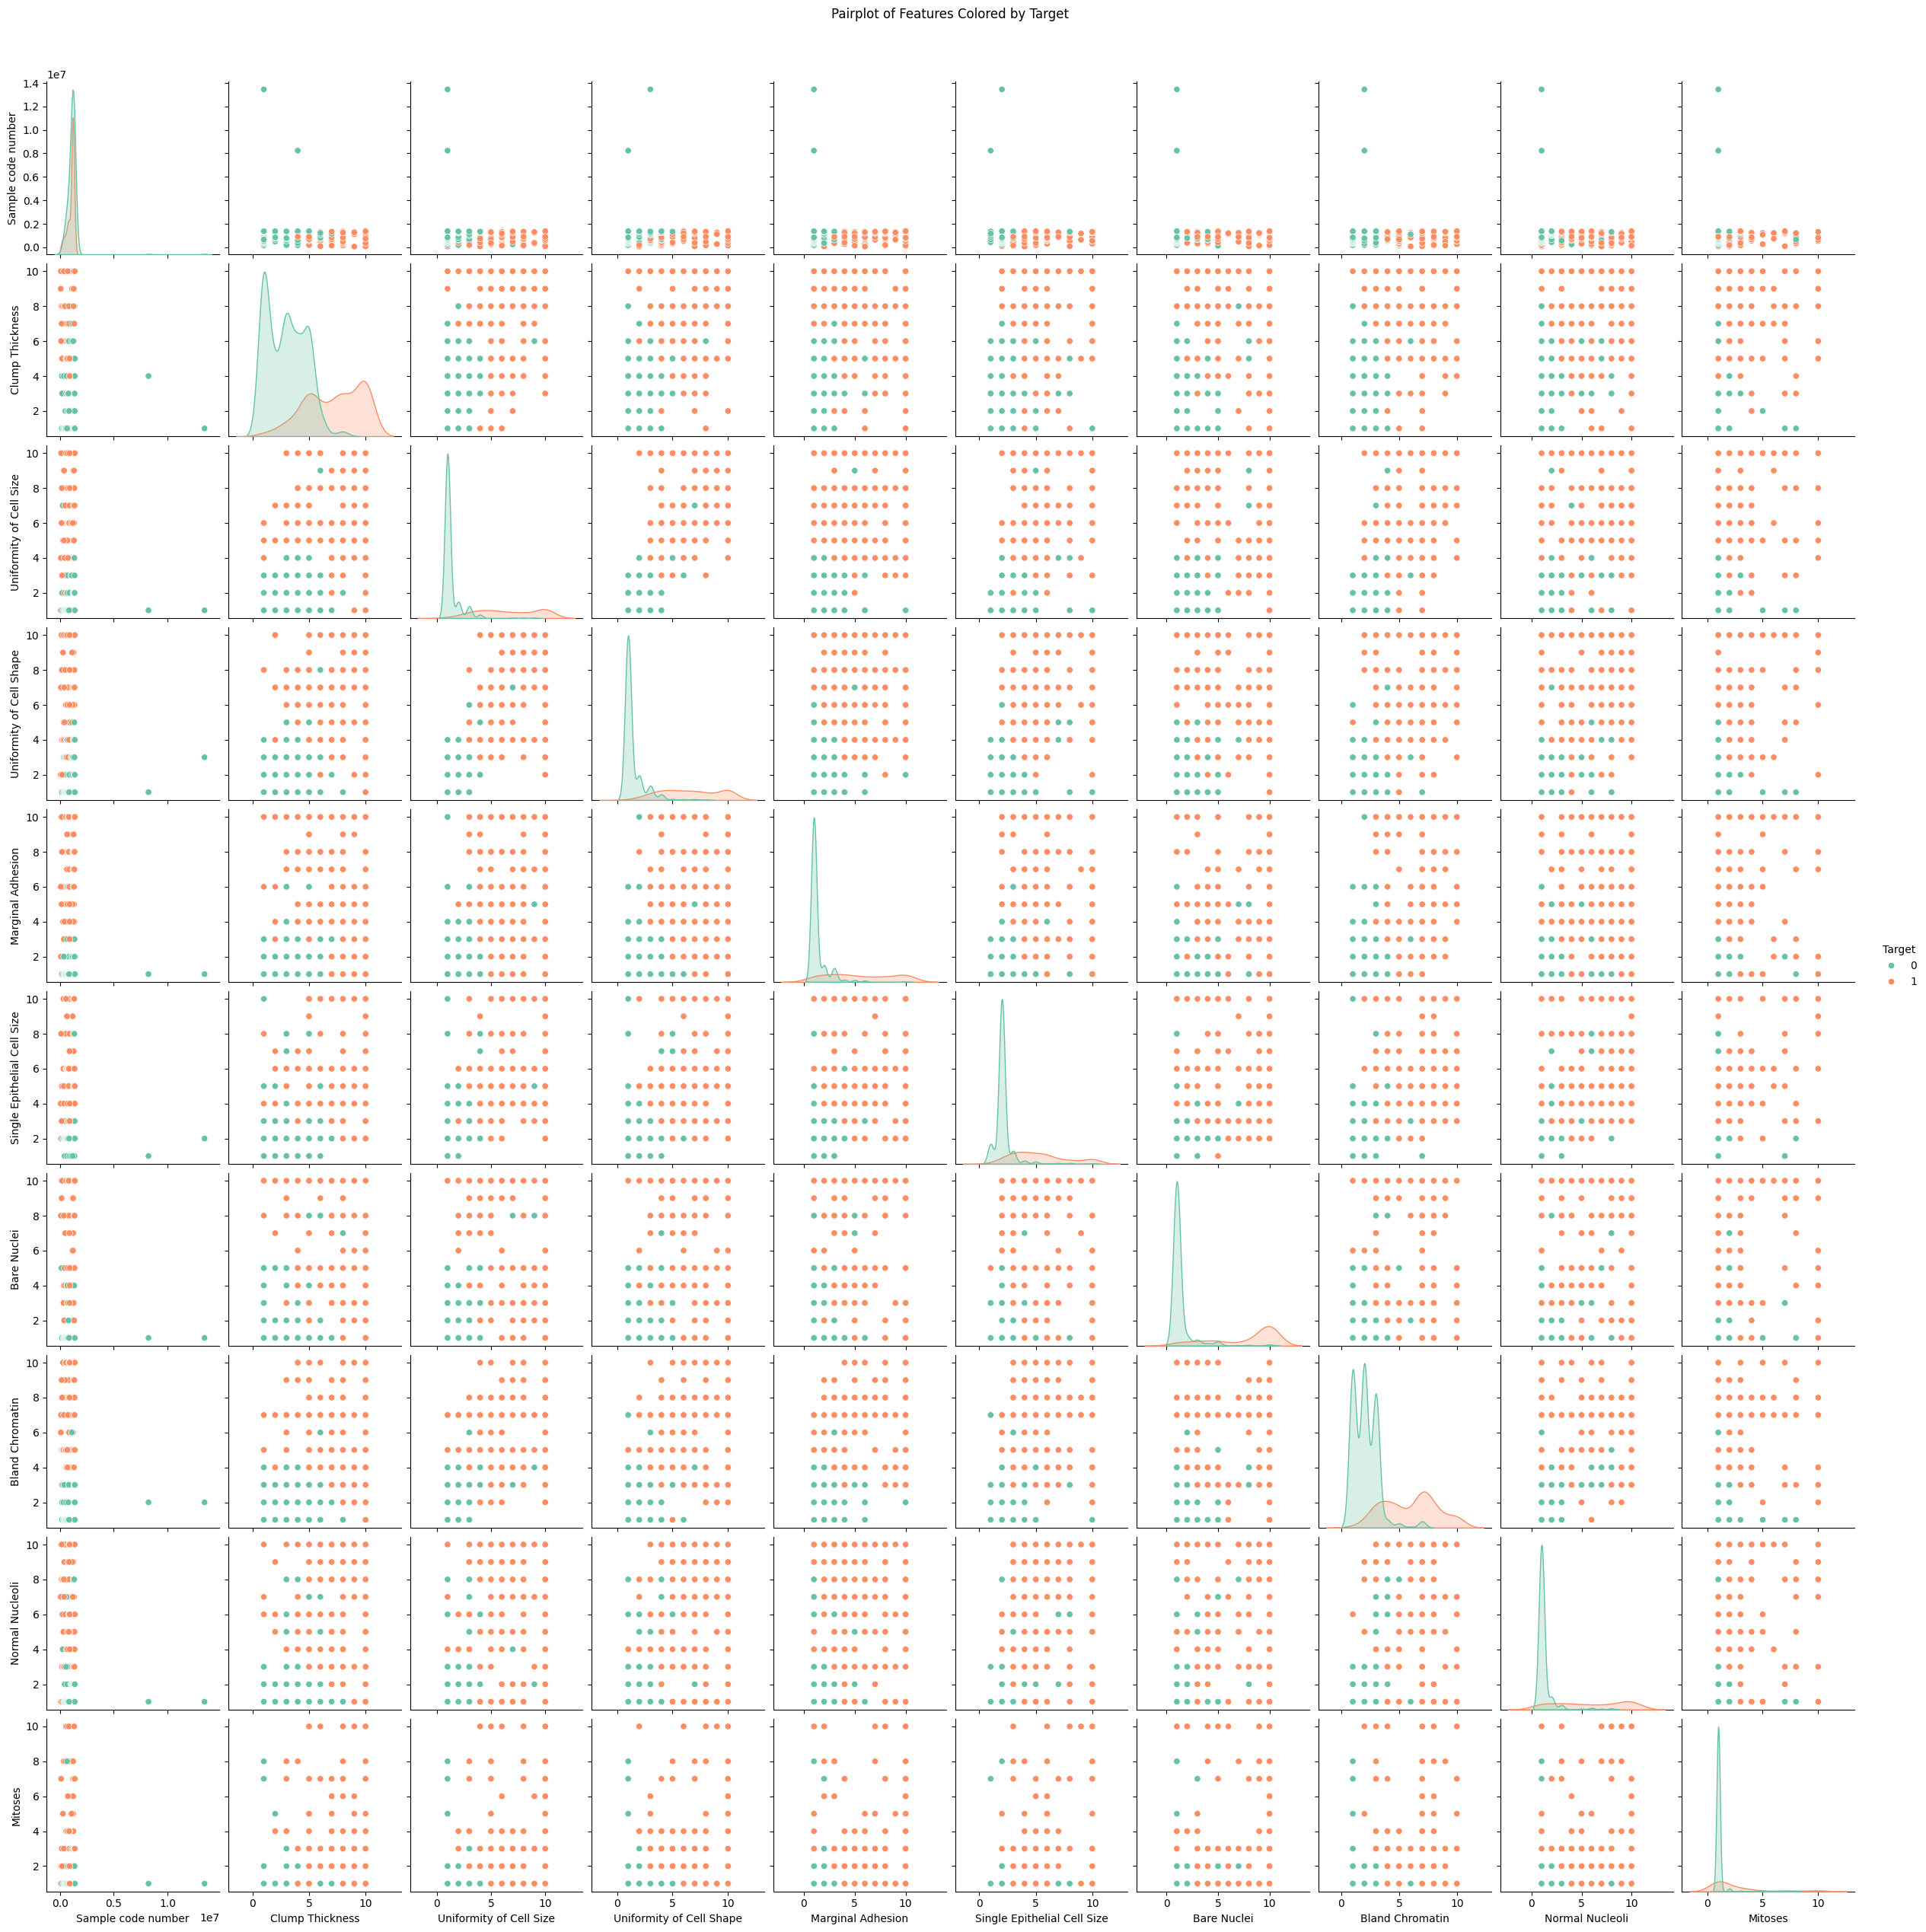

In [13]:
# Add target variable back to the dataframe for visualization
X_with_target = X.copy()
X_with_target['Target'] = y

# Pairplot with hue on the target class
sns.pairplot(X_with_target, hue='Target', diag_kind='kde', palette='Set2')
plt.suptitle("Pairplot of Features Colored by Target", y=1.02)
plt.show()


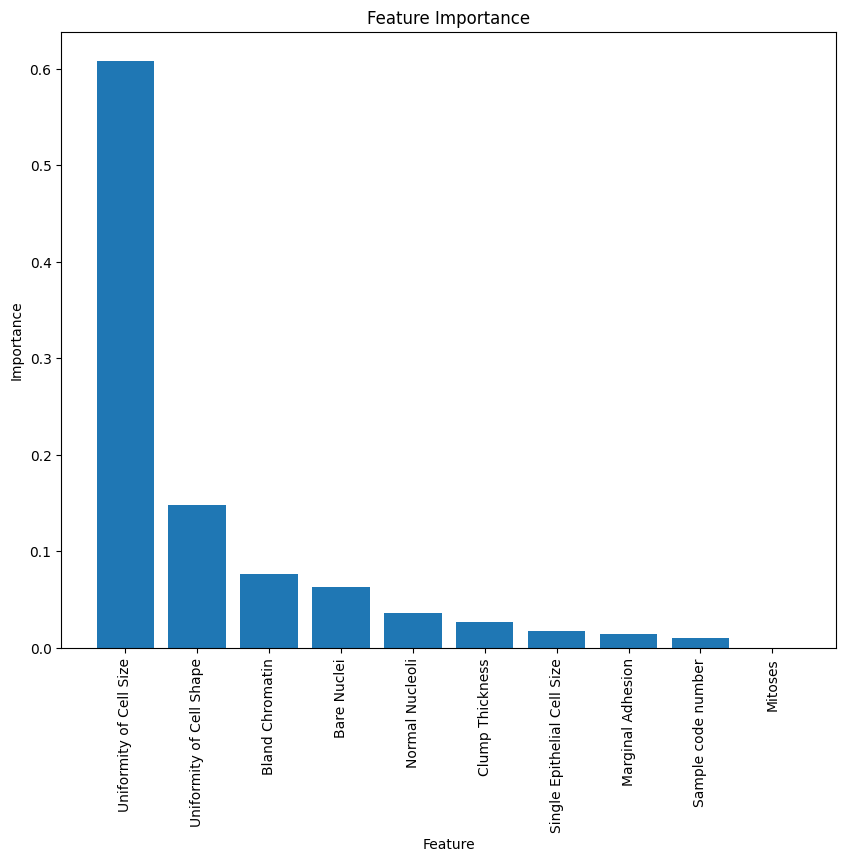

In [14]:
# Feature importance from the XGBoost model
importances = best_model.named_steps['xgb'].feature_importances_
features = X.columns
indices = np.argsort(importances)[::-1]

# Plot feature importances
plt.figure(figsize=(10, 8))
plt.title("Feature Importance")
plt.bar(range(X.shape[1]), importances[indices], align='center')
plt.xticks(range(X.shape[1]), features[indices], rotation=90)
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.show()


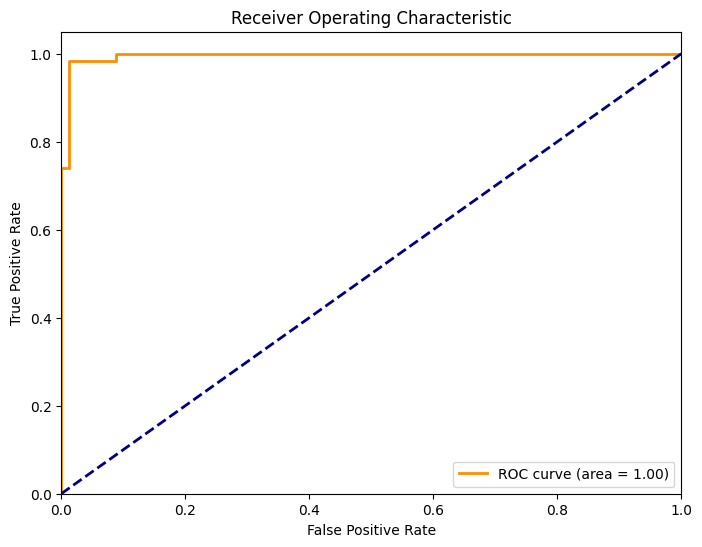

In [16]:

# Predict probabilities
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()


In [23]:
#Classification Report
print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.99      0.97        79
           1       0.98      0.95      0.96        58

    accuracy                           0.97       137
   macro avg       0.97      0.97      0.97       137
weighted avg       0.97      0.97      0.97       137



In [24]:
#Cross-validated AUC or Accuracy
auc_scores = cross_val_score(best_model, X, y, cv=5, scoring='roc_auc')
print("Cross-validated AUC scores:", auc_scores)
print("Mean AUC:", auc_scores.mean())


Cross-validated AUC scores: [0.98970037 0.98103933 0.99133895 0.99904375 0.99928977]
Mean AUC: 0.9920824345837046


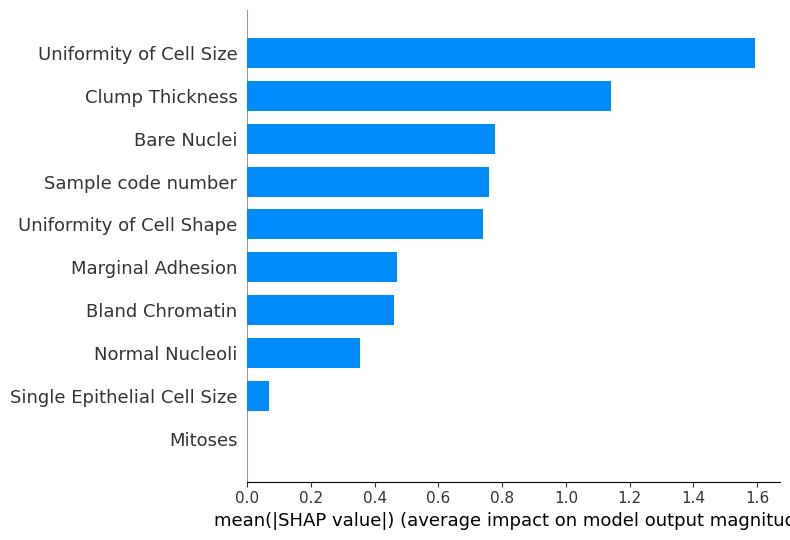

In [25]:
#SHAP values explain individual predictions, especially in healthcare.

explainer = shap.Explainer(best_model.named_steps['xgb'])
shap_values = explainer(X_test)

shap.summary_plot(shap_values, X_test, plot_type="bar")

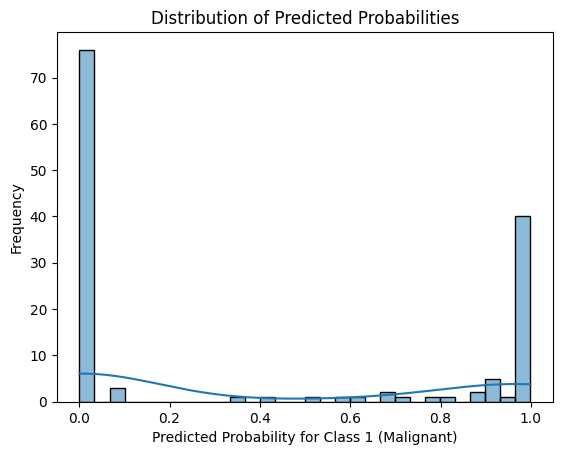

In [26]:
#Distribution of Prediction Probabilities, shows how confident your model is
sns.histplot(y_pred_proba, bins=30, kde=True)
plt.title("Distribution of Predicted Probabilities")
plt.xlabel("Predicted Probability for Class 1 (Malignant)")
plt.ylabel("Frequency")
plt.show()


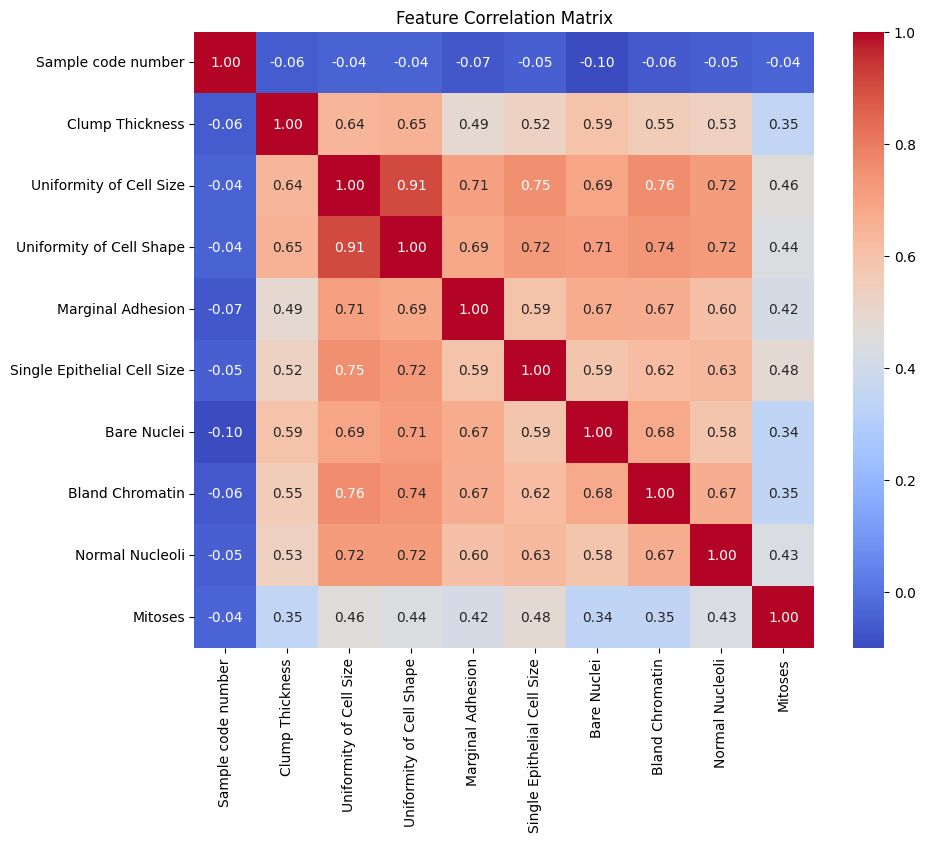

In [27]:
#Handle Correlated Features, checking for multicollinearity that might confuse your model or mask important features.
correlation_matrix = X.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Feature Correlation Matrix")
plt.show()